In [2]:
import math
import json
import os
import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta, time
from research.utils.data_access_utils import RDSAccessUtils
from research.weight_estimation.keypoint_utils.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))


In [3]:
queryCache = {}

In [4]:
def getPenDF(pen):
    akpd_filter = 0.95

    query = """
       SELECT * FROM prod.biomass_computations
        WHERE prod.biomass_computations.captured_at >= '%s'
        AND prod.biomass_computations.captured_at <= '%s'
        AND prod.biomass_computations.akpd_score > %0.4f
        AND prod.biomass_computations.pen_id = %i;
    """ % (pen['start_date'], pen['end_date'], akpd_filter, pen['pen_id'])

    if query in queryCache:
        df = queryCache[query].copy()
    else:
        df = rds_access_utils.extract_from_database(query)
        queryCache[query] = df.copy()

    df = df.sort_values('captured_at').copy(deep=True)
    df.index = pd.to_datetime(df.captured_at)
    dates = df.index.date.astype(str)
    df['date'] = dates
    df['hour'] = df.index.hour
    
    depths = []
    for idx, row in df.iterrows():
        ann, cm = row.annotation, row.camera_metadata
        wkps = pixel2world(ann['leftCrop'], ann['rightCrop'], cm)
        depth = np.median([wkp[1] for wkp in wkps.values()])
        vector = wkps['UPPER_LIP'] - wkps['TAIL_NOTCH']
        depths.append(depth)
    df['depth'] = depths
    
    return df


In [5]:
pen1 = {
    'pen_id': 60,
    'start_date': '2020-08-01 00:00',
    'end_date': '2020-08-26 00:00'
}

pen2 = {
    'pen_id': 56,
    'start_date': '2020-08-01 00:00',
    'end_date': '2020-08-26 00:00'
}

pen3 = {
    'pen_id': 145,
    'start_date': '2021-01-01 00:00',
    'end_date': '2021-02-01 00:00'
}

df1 = getPenDF(pen1)
df2 = getPenDF(pen2)
df3 = getPenDF(pen3)


In [5]:
pen4 = {
    'pen_id': 1,
    'start_date': '2020-07-01 00:00',
    'end_date': '2021-03-01 00:00'
}

df4 = getPenDF(pen4)

In [7]:
pen_ids = [1, 56, 85, 100, 114]

dfs = []

for pen_id in pen_ids:
    pen = {
        'pen_id': pen_id,
        'start_date': '2020-07-01 00:00',
        'end_date': '2020-08-01 00:00'
    }
    
    dfs.append(getPenDF(pen))

In [8]:
pen_ids2 = [1, 85, 123, 135, 144]

dfs2 = []

for pen_id in pen_ids2:
    pen = {
        'pen_id': pen_id,
        'start_date': '2020-12-01 00:00',
        'end_date': '2021-01-01 00:00'
    }
    
    dfs2.append(getPenDF(pen))

In [6]:
def getQualityDF(pen):
    query = """
       SELECT pen_id, left_crop_metadata, right_crop_metadata, captured_at FROM prod.crop_annotation 
        WHERE prod.crop_annotation.captured_at >= '%s'
        AND prod.crop_annotation.captured_at <= '%s'
        AND prod.crop_annotation.pen_id = %i;
    """ % (pen['start_date'], pen['end_date'], pen['pen_id'])

    if query in queryCache:
        df = queryCache[query].copy()
    else:
        df = rds_access_utils.extract_from_database(query)
        queryCache[query] = df.copy()

    df = df.sort_values('captured_at').copy(deep=True)
    df.index = pd.to_datetime(df.captured_at)
    dates = df.index.date.astype(str)
    df['date'] = dates
    df['hour'] = df.index.hour
    
    return df


In [10]:
pen1 = {
    'pen_id': 60,
    'start_date': '2020-08-01 00:00',
    'end_date': '2020-08-26 00:00'
}

qdf1 = getQualityDF(pen1)


In [7]:
def add_quality_fields(qdf1):
    quality_score = []
    single_quality_score = []
    combined_quality_score = []
    left_quality_score = []
    right_quality_score = []

    for index, row in qdf1.iterrows():
        qualityScore = 0
        count = 0

        if row['left_crop_metadata']:
            qualityScore = qualityScore + row['left_crop_metadata']['quality_score']
            left_quality_score.append(row['left_crop_metadata']['quality_score'])
            count = count + 1
        else:
            left_quality_score.append(None)

        if row['right_crop_metadata']:
            qualityScore = qualityScore + row['right_crop_metadata']['quality_score']
            right_quality_score.append(row['right_crop_metadata']['quality_score'])
            count = count + 1
        else:
            right_quality_score.append(None)

        if count > 0:
            quality_score.append(qualityScore / count)
        if count == 1:
            single_quality_score.append(qualityScore / count)
            combined_quality_score.append(None)
        if count == 2:
            single_quality_score.append(None)
            combined_quality_score.append(qualityScore / count)

    qdf1['quality_score'] = quality_score
    qdf1['single_quality_score'] = single_quality_score
    qdf1['combined_quality_score'] = combined_quality_score
    qdf1['left_quality_score'] = left_quality_score
    qdf1['right_quality_score'] = right_quality_score

In [13]:
add_quality_fields(qdf1)

In [142]:
np.mean(qdf1['left_quality_score']), np.mean(qdf1['right_quality_score']), np.mean(qdf1['quality_score']), np.mean(qdf1['single_quality_score']), np.mean(qdf1['combined_quality_score'])

(0.1473933220233793,
 0.1571329645676279,
 0.12604587455761115,
 0.04298229843014844,
 0.20201559509256084)

In [148]:
np.mean(~np.isnan(qdf1['left_quality_score'])), np.mean(~np.isnan(qdf1['right_quality_score'])), np.mean(~np.isnan(qdf1['quality_score'])), np.mean(~np.isnan(qdf1['single_quality_score'])), np.mean(~np.isnan(qdf1['combined_quality_score']))

(0.7849112629569842,
 0.7373917884837828,
 1.0,
 0.47769694855923295,
 0.522303051440767)

In [14]:
quality_scores = []
left_quality_scores = []
right_quality_scores = []
single_quality_scores = []
combined_quality_scores = []
left_quality_scores_pct = []
right_quality_scores_pct = []
single_quality_scores_pct = []
combined_quality_scores_pct = []
hours = []
raw_hours = []

dates = sorted(list(set(qdf1['date'])))

for index, date in enumerate(dates):
    datehours = sorted(list(set(qdf1[qdf1.date == date]['hour'])))
    
    for hour in datehours:
        quality_scores.append(np.mean(qdf1[(qdf1.date == date) & (qdf1.hour == hour)]['quality_score']))
        left_quality_scores.append(np.mean(qdf1[(qdf1.date == date) & (qdf1.hour == hour)]['left_quality_score']))
        right_quality_scores.append(np.mean(qdf1[(qdf1.date == date) & (qdf1.hour == hour)]['right_quality_score']))
        single_quality_scores.append(np.mean(qdf1[(qdf1.date == date) & (qdf1.hour == hour)]['single_quality_score']))
        combined_quality_scores.append(np.mean(qdf1[(qdf1.date == date) & (qdf1.hour == hour)]['combined_quality_score']))
        left_quality_scores_pct.append(np.mean(~np.isnan(qdf1[(qdf1.date == date) & (qdf1.hour == hour)]['left_quality_score'])))
        right_quality_scores_pct.append(np.mean(~np.isnan(qdf1[(qdf1.date == date) & (qdf1.hour == hour)]['right_quality_score'])))
        single_quality_scores_pct.append(np.mean(~np.isnan(qdf1[(qdf1.date == date) & (qdf1.hour == hour)]['single_quality_score'])))
        combined_quality_scores_pct.append(np.mean(~np.isnan(qdf1[(qdf1.date == date) & (qdf1.hour == hour)]['combined_quality_score'])))
        hours.append(index * 24 + hour)
        raw_hours.append(hour)
        
quality_scores = np.array(quality_scores)
left_quality_scores = np.array(left_quality_scores)
right_quality_scores = np.array(right_quality_scores)
single_quality_scores = np.array(single_quality_scores)
combined_quality_scores = np.array(combined_quality_scores)
left_quality_scores_pct = np.array(left_quality_scores_pct)
right_quality_scores_pct = np.array(right_quality_scores_pct)
single_quality_scores_pct = np.array(single_quality_scores_pct)
combined_quality_scores_pct = np.array(combined_quality_scores_pct)
hours = np.array(hours)
raw_hours = np.array(raw_hours)

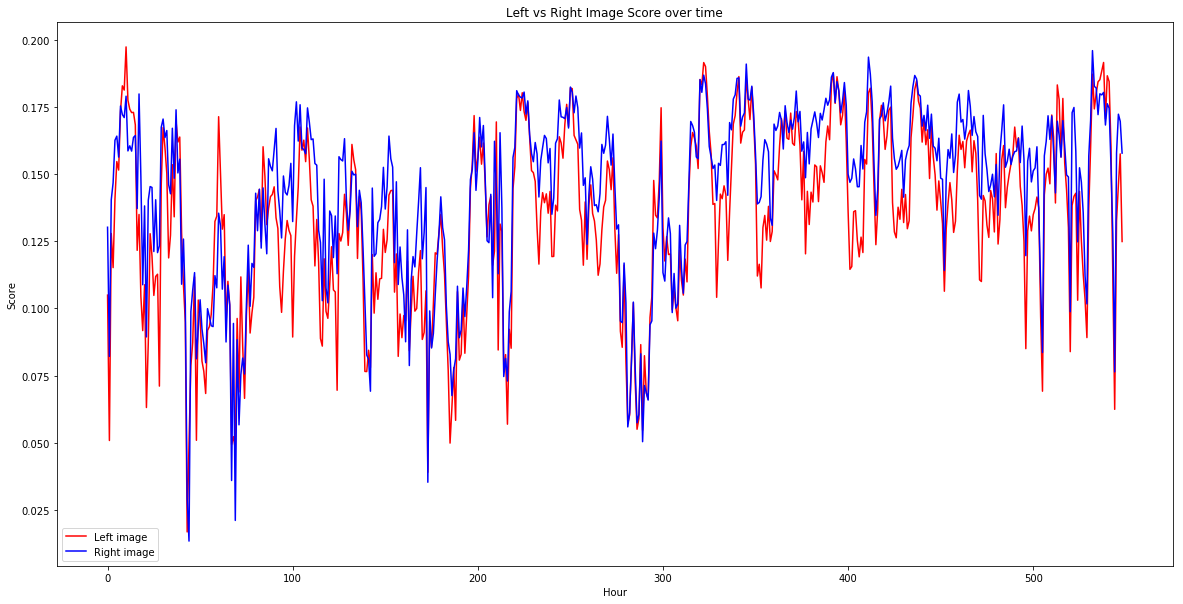

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# plt.plot(quality_scores, color = 'green')
plt.plot(left_quality_scores, color = 'red', label = 'Left image')
plt.plot(right_quality_scores, color = 'blue', label = 'Right image')
plt.xlabel('Hour')
plt.ylabel('Score')
plt.title('Left vs Right Image Score over time')
plt.legend()

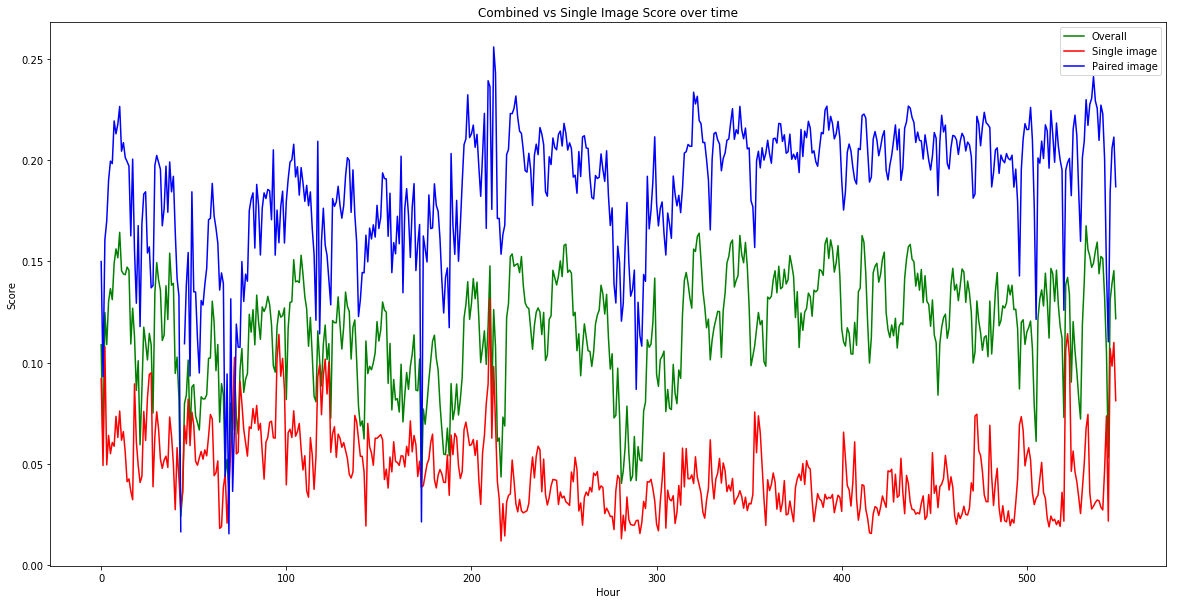

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

plt.plot(quality_scores, color = 'green', label = 'Overall')
plt.plot(single_quality_scores, color = 'red', label = 'Single image')
plt.plot(combined_quality_scores, color = 'blue', label = 'Paired image')
plt.xlabel('Hour')
plt.ylabel('Score')
plt.title('Combined vs Single Image Score over time')
plt.legend()


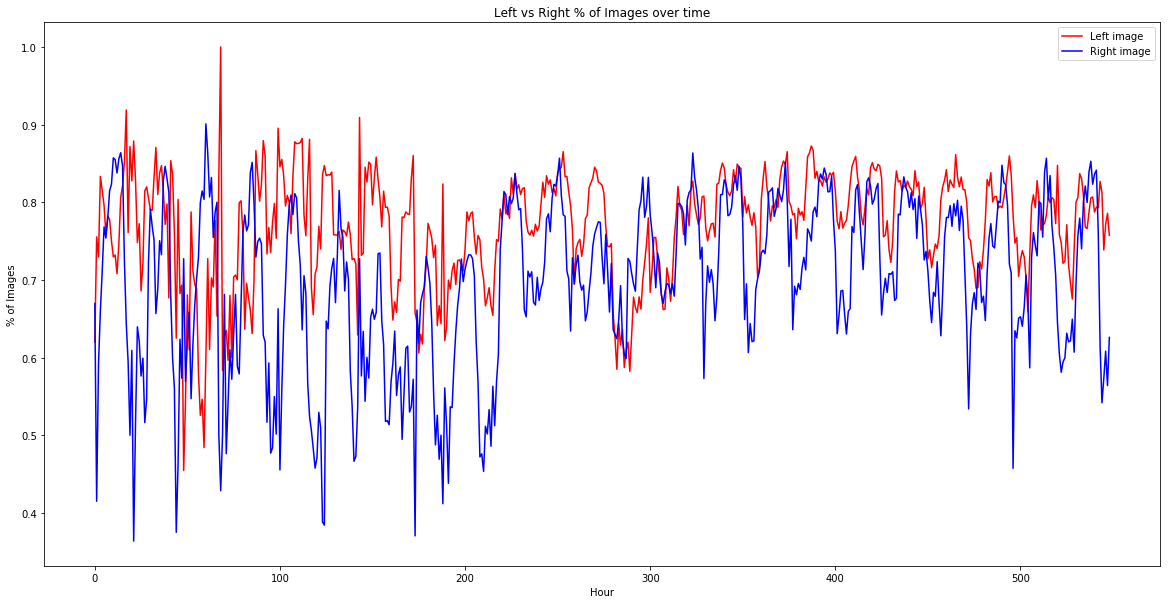

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

plt.plot(left_quality_scores_pct, color = 'red', label = 'Left image')
plt.plot(right_quality_scores_pct, color = 'blue', label = 'Right image')
plt.xlabel('Hour')
plt.ylabel('% of Images')
plt.title('Left vs Right % of Images over time')
plt.legend()

No handles with labels found to put in legend.


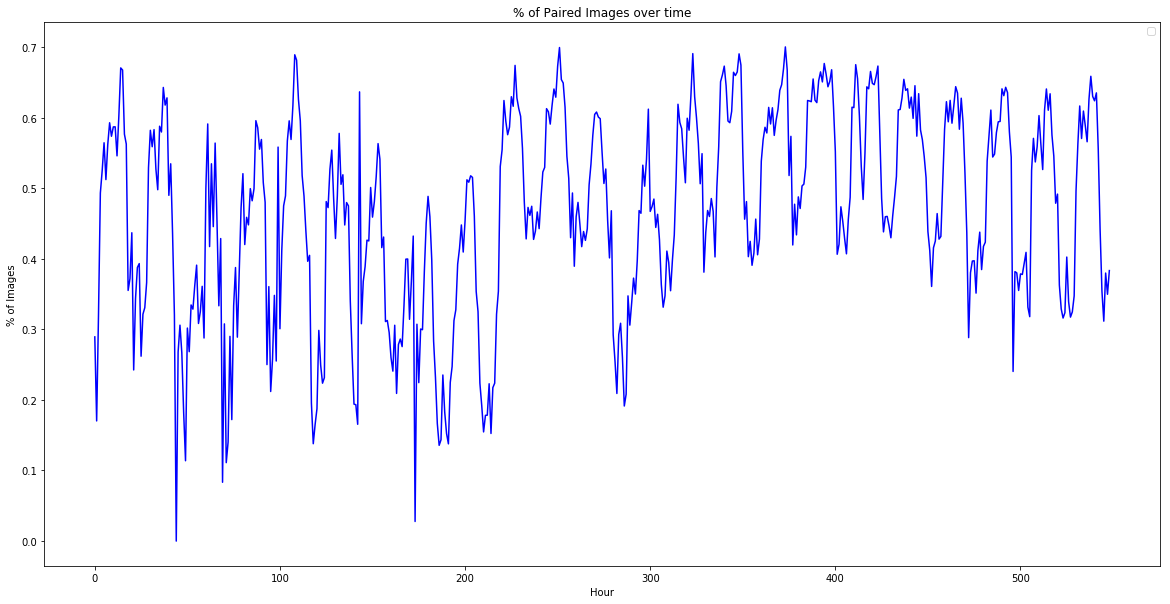

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# plt.plot(single_quality_scores_pct, color = 'red')
plt.plot(combined_quality_scores_pct, color = 'blue')
plt.xlabel('Hour')
plt.ylabel('% of Images')
plt.title('% of Paired Images over time')
plt.legend()

Text(0.5, 1.0, 'Avg Paired Image Score vs Hour')

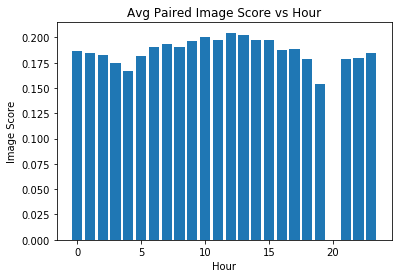

In [30]:
avg_quality_by_hour = []

for hour in raw_hours:
    mask = raw_hours == hour
    avg_quality_by_hour.append(np.mean(combined_quality_scores[mask]))
    
plt.bar(raw_hours, avg_quality_by_hour)
plt.xlabel('Hour')
plt.ylabel('Image Score')
plt.title('Avg Paired Image Score vs Hour')

Text(0.5, 1.0, 'Avg Single Image Score vs Hour')

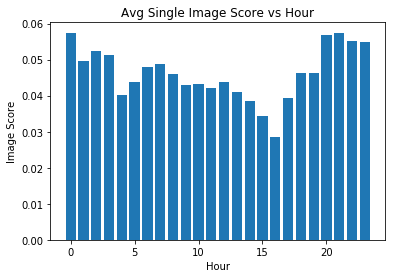

In [31]:
avg_quality_by_hour = []

for hour in raw_hours:
    mask = raw_hours == hour
    avg_quality_by_hour.append(np.mean(single_quality_scores[mask]))
    
plt.bar(raw_hours, avg_quality_by_hour)
plt.xlabel('Hour')
plt.ylabel('Image Score')
plt.title('Avg Single Image Score vs Hour')

Text(0.5, 1.0, '% of Paired Images vs Hour')

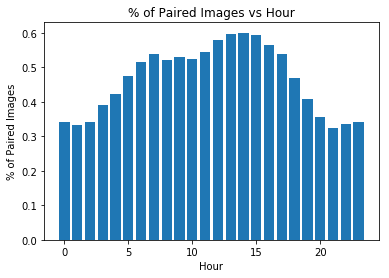

In [32]:
avg_quality_by_hour = []

for hour in raw_hours:
    mask = raw_hours == hour
    avg_quality_by_hour.append(np.mean(combined_quality_scores_pct[mask]))
    
plt.bar(raw_hours, avg_quality_by_hour)
plt.xlabel('Hour')
plt.ylabel('% of Paired Images')
plt.title('% of Paired Images vs Hour')

Text(0.5, 1.0, 'Overall Image Score vs Hour')

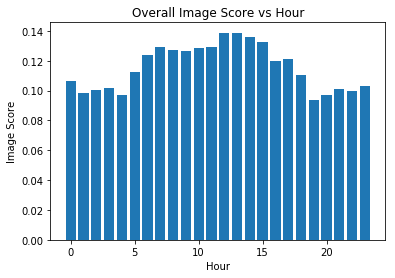

In [33]:
avg_quality_by_hour = []

for hour in raw_hours:
    mask = raw_hours == hour
    avg_quality_by_hour.append(np.mean(quality_scores[mask]))
    
plt.bar(raw_hours, avg_quality_by_hour)
plt.xlabel('Hour')
plt.ylabel('Image Score')
plt.title('Overall Image Score vs Hour')

In [8]:
def get_indicator(df):
    depths = []
    widths = []
    heights = []

    for index, row in df.iterrows():
    #     width = row['annotation']['leftCrop'][0]['xCrop']
    #     height = row['annotation']['leftCrop'][0]['yCrop']

        ann, cm = row.annotation, row.camera_metadata
        wkps = pixel2world(ann['leftCrop'], ann['rightCrop'], cm)
        width = np.max([wkp[0] for wkp in wkps.values()]) - np.min([wkp[0] for wkp in wkps.values()])
        height = np.max([wkp[2] for wkp in wkps.values()]) - np.min([wkp[2] for wkp in wkps.values()])

        widths.append(width)
        heights.append(height)
        depths.append(row['depth'])

    depths = np.array(depths)
    widths = np.array(widths)
    heights = np.array(heights)
    
    indicator = depths ** 2 / (widths * heights) * 0.2
    
    return depths, indicator

In [75]:
depths1, indicator1 = get_indicator(df1)
depths2, indicator2 = get_indicator(df2)
depths3, indicator3 = get_indicator(df3)

In [9]:
dates = [
    '2020-07-01',
    '2020-08-01',
    '2020-09-01',
    '2020-10-01',
    '2020-11-01',
    '2020-12-01',
    '2021-01-01',
    '2021-02-01'
]

In [ ]:
results = []

for index, start_date in enumerate(dates):
    print(start_date)
    if index == len(dates) - 1:
        end_date = '2021-03-01'
    else:
        end_date = dates[index + 1]
    mask = (df4['date'] >= start_date) & (df4['date'] < end_date)
    df4a = df4[mask]
    
    pen = {
        'pen_id': 1,
        'start_date': start_date,
        'end_date': end_date
    }
    
    qdf1 = getQualityDF(pen)
    add_quality_fields(qdf1)
    
    depths4a, indicator4a = get_indicator(df4a)
    
    results.append((start_date, depths4a, indicator4a, qdf1))

2020-07-01
2020-08-01
2020-09-01


In [87]:
results2 = []

for index, df in enumerate(dfs):
    depths4a, indicator4a = get_indicator(df)
    
    results2.append((pen_ids[index], depths4a, indicator4a))

In [95]:
results3 = []

for index, df in enumerate(dfs2):
    depths4a, indicator4a = get_indicator(df)
    
    results3.append((pen_ids2[index], depths4a, indicator4a))

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Text(0.5, 1.0, 'Depth vs Cropper Recall Indicator - Pen 1')

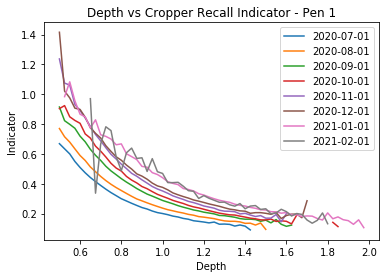

In [92]:
step = 0.025

my_depths = np.arange(0.5, 2, step)

for result in results:
    start_date, depths4a, indicator4a = result
    
    my_indicator1 = []
    
    for depth in my_depths:
        mask = (depths4a > depth) & (depths4a < depth + step)
        my_indicator1.append(np.sum(mask) / np.sum(indicator4a[mask]))

    plt.plot(my_depths, my_indicator1, label = start_date)
    
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Indicator')
plt.title('Depth vs Cropper Recall Indicator - Pen 1')

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Text(0.5, 1.0, 'Depth vs Cropper Recall Indicator - July 2020')

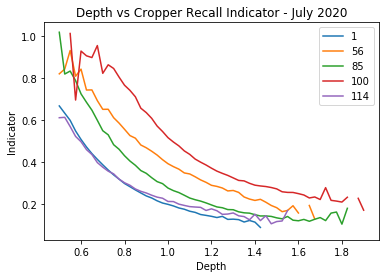

In [93]:
step = 0.025

my_depths = np.arange(0.5, 2, step)

for result in results2:
    pen_id, depths4a, indicator4a = result
    
    my_indicator1 = []
    
    for depth in my_depths:
        mask = (depths4a > depth) & (depths4a < depth + step)
        my_indicator1.append(np.sum(mask) / np.sum(indicator4a[mask]))

    plt.plot(my_depths, my_indicator1, label = pen_id)
    
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Indicator')
plt.title('Depth vs Cropper Recall Indicator - July 2020')

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Text(0.5, 1.0, 'Depth vs Cropper Recall Indicator - Dec 2020')

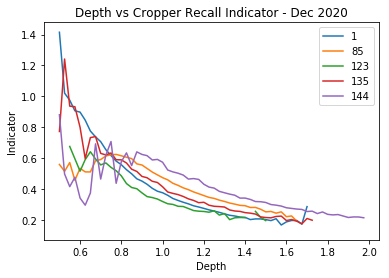

In [96]:
step = 0.025

my_depths = np.arange(0.5, 2, step)

for result in results3:
    pen_id, depths4a, indicator4a = result
    
    my_indicator1 = []
    
    for depth in my_depths:
        mask = (depths4a > depth) & (depths4a < depth + step)
        my_indicator1.append(np.sum(mask) / np.sum(indicator4a[mask]))

    plt.plot(my_depths, my_indicator1, label = pen_id)
    
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Indicator')
plt.title('Depth vs Cropper Recall Indicator - Dec 2020')

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


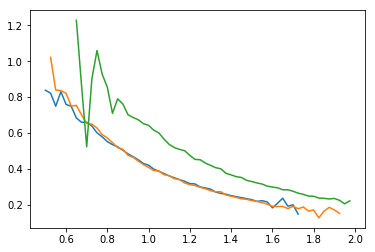

In [76]:
step = 0.025

my_depths = np.arange(0.5, 2, step)

my_indicator1 = []
my_indicator2 = []
my_indicator3 = []

for depth in my_depths:
    mask = (depths1 > depth) & (depths1 < depth + step)
    my_indicator1.append(np.sum(mask) / np.sum(indicator1[mask]))
    mask = (depths2 > depth) & (depths2 < depth + step)
    my_indicator2.append(np.sum(mask) / np.sum(indicator2[mask]))
    mask = (depths3 > depth) & (depths3 < depth + step)
    my_indicator3.append(np.sum(mask) / np.sum(indicator3[mask]))

plt.plot(my_depths, my_indicator1)
plt.plot(my_depths, my_indicator2)
plt.plot(my_depths, my_indicator3)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


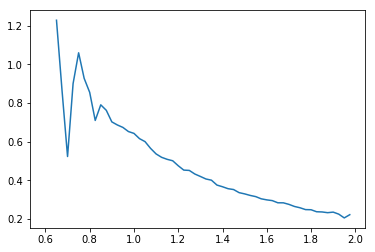

In [101]:
step = 0.025

my_depths = np.arange(0.5, 2, step)
my_indicator = []

for depth in my_depths:
    mask = (depths > depth) & (depths < depth + step)
    my_indicator.append(np.sum(mask) / np.sum(indicator[mask]))
#     my_indicator.append(np.mean(indicator[mask]))

plt.plot(my_depths, my_indicator)

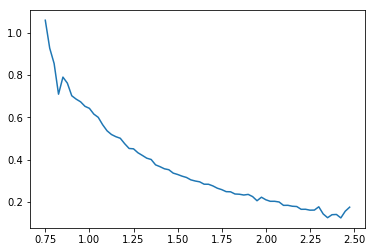

In [72]:
step = 0.025

my_depths = np.arange(0.75, 2.5, step)
my_indicator = []

for depth in my_depths:
    mask = (depths > depth) & (depths < depth + step)
    my_indicator.append(np.sum(mask) / np.sum(indicator[mask]))
#     my_indicator.append(np.mean(indicator[mask]))

plt.plot(my_depths, my_indicator)